In [ ]:
#importing the libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM , Dense,GlobalMaxPooling1D,Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [ ]:
#importing the dataset
with open('contenta.json') as contenta:
  data1 = json.load(contenta)

In [ ]:
#getting all the data to lists
tags = []
inputs = []
responses={}
for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['input']:
    inputs.append(lines)
    tags.append(intent['tag'])

In [ ]:
#converting to dataframe
data = pd.DataFrame({"inputs":inputs,
                     "tags":tags})

In [ ]:
#printing the data
data

,inputs,tags
0,hola,saludo
1,hola,saludo
2,encantado de conocerte,saludo
3,"hola, ¿esta es la organización de los piratas",saludo
4,algún pirata aquí?,saludo
...,...,...
72,cuéntame más sobre los requisitos previos requ...,requisitos previos
73,dar más detalles sobre los requisitos previos,requisitos previos
74,¿Cuáles son los requisitos,requisitos previos
75,cuáles son los requisitos básicos,requisitos previos


In [ ]:
data = data.sample(frac=1)

In [ ]:
#removing punctuations
import string
data['inputs'] = data['inputs'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['inputs'] = data['inputs'].apply(lambda wrd: ''.join(wrd))
data

,inputs,tags
28,¿estás bien,howami
35,¿qué eres,quien eres tu
42,¿cómo te llamo,quien eres tu
37,¿eres un chatbot,quien eres tu
63,¿dónde está ubicado el centro de sombreros de ...,dondeestaelcentro
...,...,...
21,está bien te veré más tarde,adiós
19,te alcanzaré más tarde,adiós
59,como inscribirse,unirse
70,¿cuáles son los requisitos previos,requisitos previos


In [ ]:
#tokenize the data
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['inputs'])
train = tokenizer.texts_to_sequences(data['inputs'])
#apply padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(train)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])

In [ ]:
input_shape = x_train.shape[1]
print(input_shape)

9


In [ ]:
#define vocabulary
vocabulary = len(tokenizer.word_index)
print("number of unique words : ",vocabulary)
output_length = le.classes_.shape[0]
print("output length: ",output_length)

number of unique words :  110
output length:  8


In [ ]:
#creating the model

i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1,10)(i)
x = LSTM(10,return_sequences=True)(x)
x = Flatten()(x)
x = Dense(output_length,activation="softmax")(x)
model  = Model(i,x)

In [ ]:
#compiling the model
model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

In [ ]:
#training the model
train = model.fit(x_train,y_train,epochs=200)


Epoch 1/200
3/3 [==============================] - 2s 8ms/step - loss: 2.0785 - accuracy: 0.1169
Epoch 2/200
3/3 [==============================] - 0s 7ms/step - loss: 2.0747 - accuracy: 0.1429
Epoch 3/200
3/3 [==============================] - 0s 11ms/step - loss: 2.0708 - accuracy: 0.1818
Epoch 4/200
3/3 [==============================] - 0s 11ms/step - loss: 2.0671 - accuracy: 0.2727
Epoch 5/200
3/3 [==============================] - 0s 9ms/step - loss: 2.0632 - accuracy: 0.2597
Epoch 6/200
3/3 [==============================] - 0s 8ms/step - loss: 2.0585 - accuracy: 0.2597
Epoch 7/200
3/3 [==============================] - 0s 8ms/step - loss: 2.0540 - accuracy: 0.2727
Epoch 8/200
3/3 [==============================] - 0s 8ms/step - loss: 2.0487 - accuracy: 0.2078
Epoch 9/200
3/3 [==============================] - 0s 8ms/step - loss: 2.0431 - accuracy: 0.1948
Epoch 10/200
3/3 [==============================] - 0s 7ms/step - loss: 2.0370 - accuracy: 0.1948
Epoch 11/200
3/3 [=========

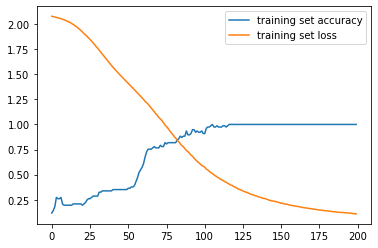

In [ ]:
#plotting model accuracy
plt.plot(train.history['accuracy'],label='training set accuracy')
plt.plot(train.history['loss'],label='training set loss')
plt.legend()

In [ ]:
#chatting
import random


while True:
  texts_p = []
  prediction_input = input('You : ')

  #removing punctuation and converting to lowercase
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  #tokenizing and padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],input_shape)

  #getting output from model
  output = model.predict(prediction_input)
  output = output.argmax()

  #finding the right tag and predicting
  response_tag = le.inverse_transform([output])[0]
  print("Going Merry : ",random.choice(responses[response_tag]))
  if response_tag == "goodbye":
    break